# Interaction with the World Homework (#3)
Python Computing for Data Science (c) J Bloom, UC Berkeley, 2016

# 1) Monty: The Python Siri

Let's make a Siri-like program with the following properties:
   - record your voice command
   - use a webservice to parse that sound file into text
   - based on what the text, take three different types of actions:
       - send an email to yourself
       - do some math
       - tell a joke

So for example, if you say "Monty: email me with subject hello and body goodbye", it will email you with the appropriate subject and body. If you say "Monty: tell me a joke" then it will go to the web and find a joke and print it for you. If you say, "Monty: calculate two times three" it should response with printing the number 6.

Hint: you can use speed-to-text apps like Houndify to return the text (but not do the actions). You'll need to sign up for a free API and then follow documentation instructions for using the service within Python. 

In [176]:
import pyaudio
import wave
import houndify
import speech_recognition as sr
import sys
from bs4 import BeautifulSoup
try:
    # For Python 3.0 and later
    from urllib.request import urlopen
except ImportError:
    # Fall back to Python 2's urllib2
    from urllib2 import urlopen
    
import smtplib
from email.mime.text import MIMEText
from email.message import EmailMessage
from email.headerregistry import Address
from email.utils import make_msgid

In [71]:
# listen and record command
def record(WAVE_OUTPUT_FILENAME):
    chunk = 1024
    FORMAT = pyaudio.paInt16
    CHANNELS = 1
    RATE = 8000
    RECORD_SECONDS = 7
    p = pyaudio.PyAudio()
    stream = p.open(format = FORMAT,
        channels = CHANNELS,
        rate = RATE,
        input = True,
        frames_per_buffer = chunk)
    all = []
    for i in range(0, int(RATE / chunk * RECORD_SECONDS)):
        data = stream.read(chunk)
        all.append(data)
    print("* done recording")
    stream.close()
    p.terminate()
    
    data = b"".join(all)
    wf = wave.open(WAVE_OUTPUT_FILENAME, "wb")
    wf.setnchannels(CHANNELS)
    wf.setsampwidth(p.get_sample_size(FORMAT))
    wf.setframerate(RATE)
    wf.writeframes(data)
    wf.close()

In [328]:
def speechtotext(audiofile):
    """
    using HOUNDIFY to parse audiofile into text
    """
    CLIENT_ID = "rXaxIajhCsCO5JSgTvSEBg=="
    CLIENT_KEY = "MyIuxruWQNgEjaWvWCvyYBbOQELBmZKCWDHpgIFrCgI5m3d-H1UVgbM5-RPyQ1czKsIJ1JGxaPzUmU5wnlvgSQ=="

    client = houndify.StreamingHoundClient(CLIENT_ID, CLIENT_KEY, "test user", sampleRate=8000)

    !houndify/sample_wave.py $CLIENT_ID $CLIENT_KEY $audiofile > result.txt
    
    # parse and obtain the last line 
    with open("result.txt") as f:
        lst_line = None
        for line in f:
            if 'Partial transcript: ' in line:
                lst_line = line
        lst_line = lst_line.split(': ')[1]
        lst_line = lst_line.strip('\n')
        print(lst_line, "\n")
    return(lst_line)

In [245]:
email = speechtotext("email.wav")

In [165]:
def tell_joke(url = "http://www.laughfactory.com/jokes/food-jokes"):    
    response = urlopen(url)
    html = response.read()
    response.close()
    soup = BeautifulSoup(html,"html.parser")
    forms = soup.findAll("div", class_="joke-text")
    joke = forms[-1].get_text()
    print((" ").join(joke.split()))

In [174]:
tell_joke()

Q: Have you ever had Ethiopian food? A: Neither have they.


In [355]:
def send_email(text):
    text = text.split(" ")
    subject = "subject"
    body = "body"
    for i in range(len(text)):
        if b[i] == 'subject':
            start = i+1
        if b[i] == 'body':
            subject = (" ").join(b[start:i-1])
            body = (" ").join(b[i+1:])

    from_email = "shimanluck626@gmail.com"
    to_email = "shimanluck626@gmail.com"
    msg = EmailMessage()
    msg['Subject'] = subject
    msg['From'] = from_email
    msg['To'] = to_email
    msg.set_content(body)

    mailServer = smtplib.SMTP("smtp.gmail.com", 587)
    mailServer.starttls()
    mailServer.login(from_email, "hahahahahaha")
    mailServer.sendmail(from_email, to_email, msg.as_string())
    mailServer.close()

In [243]:
send_email(email)

In [271]:
# reference: https://github.com/akshaynagpal/w2n/blob/master/word2number/w2n.py
# transfered strings into numerical number
american_number_system = {
    'zero': 0,
    'one': 1,
    'two': 2,
    'three': 3,
    'four': 4,
    'five': 5,
    'six': 6,
    'seven': 7,
    'eight': 8,
    'nine': 9,
    'ten': 10,
    'eleven': 11,
    'twelve': 12,
    'thirteen': 13,
    'fourteen': 14,
    'fifteen': 15,
    'sixteen': 16,
    'seventeen': 17,
    'eighteen': 18,
    'nineteen': 19,
    'twenty': 20,
    'thirty': 30,
    'forty': 40,
    'fifty': 50,
    'sixty': 60,
    'seventy': 70,
    'eighty': 80,
    'ninety': 90,
    'hundred': 100,
    'thousand': 1000,
    'million': 1000000,
    'billion': 1000000000
}

def word_to_num(number_sentence):
    number_sentence = number_sentence.lower()
    split_words = number_sentence.split()  # split sentence into words
    clean_numbers = []  # removing and, & etc.
    for word in split_words:
        if word in american_number_system:
            clean_numbers.append(word)

    # Error message if the user enters invalid input!        
    if len(clean_numbers) == 0:
        return "Error: Please enter a valid number word (eg. two million twenty three thousand and forty nine) "

    billion_index = clean_numbers.index('billion') if 'billion' in clean_numbers else -1
    million_index = clean_numbers.index('million') if 'million' in clean_numbers else -1
    thousand_index = clean_numbers.index('thousand') if 'thousand' in clean_numbers else -1

    total_sum = 0
    if billion_index>-1 :
        billion_multiplier = number_formation(clean_numbers[0:billion_index])
        # print "billion_multiplier",str(billion_multiplier)
        total_sum += billion_multiplier * 1000000000

    if million_index>-1 :
        if billion_index>-1:
            million_multiplier = number_formation(clean_numbers[billion_index+1:million_index])
        else:
            million_multiplier = number_formation(clean_numbers[0:million_index])
        total_sum += million_multiplier * 1000000
        # print "million_multiplier",str(million_multiplier)

    if thousand_index > -1:
        if million_index > -1:
            thousand_multiplier = number_formation(clean_numbers[million_index+1:thousand_index])
        elif billion_index>-1 and million_index==-1:
            thousand_multiplier = number_formation(clean_numbers[billion_index+1:thousand_index])
        else:
            thousand_multiplier = number_formation(clean_numbers[0:thousand_index])
        total_sum += thousand_multiplier * 1000
        # print "thousand_multiplier",str(thousand_multiplier)

    if thousand_index>-1 and thousand_index != len(clean_numbers)-1:
        hundreds = number_formation(clean_numbers[thousand_index+1:])
    elif million_index>-1 and million_index != len(clean_numbers)-1:
        hundreds = number_formation(clean_numbers[million_index+1:])
    elif billion_index>-1 and billion_index != len(clean_numbers)-1:
        hundreds = number_formation(clean_numbers[billion_index+1:])
    elif thousand_index==-1 and million_index==-1 and billion_index==-1:
        hundreds = number_formation(clean_numbers)
    else:
        hundreds = 0
    total_sum += hundreds
    # print "hundreds",str(hundreds)
    return total_sum


def number_formation(number_words):
    numbers = []
    for number_word in number_words:
        numbers.append(american_number_system[number_word])
    if len(numbers)==4:
        return (numbers[0]*numbers[1])+numbers[2]+numbers[3]
    elif len(numbers)==3:
        return numbers[0]*numbers[1] + numbers[2]
    elif len(numbers)==2:
        if 100 in numbers:
            return numbers[0]*numbers[1]
        else:
            return numbers[0]+numbers[1]
    else:
        return numbers[0]

In [354]:
def do_math(text):
    text = text.split(" ")
    start = 0
    nums = []
    operations = {'plus':1, 'minus':2, 'times':3, 'devided':4}
    flag = 0
    for i in range(len(text)):
        if flag == 0:
            if text[i] == 'calculate':
                start = i+1
                flag = 1
            continue
        if text[i] not in american_number_system:
            if text[i] != 'and':
                nums.append(word_to_num((" ").join(text[start:i])))
                start = i+1
                operation = text[i]

    nums.append(word_to_num((" ").join(text[start:])))
    if operation == 'plus' or operation == 'add':
        return (nums[0] + nums[1])
    elif operation == 'minus':
        return (nums[0] - nums[1])
    elif operation == 'multiple' or operation == 'times':
        return (nums[0] * nums[1])
    else:
        return (nums[0] / nums[1])

In [347]:
# main function
def main():
    print("What do you want to do?")
    record("result.wav")
    text = speechtotext("result.wav")
    
    if 'email' in text:
        print("Sending the email...\n")
        send_email(text)
    elif 'joke' in text:
        print("You want a joke? Sure!\n")
        tell_joke()
    else:
        print("Let's do math!\n")
        result = do_math(text)
        print(result)

In [356]:
main()

What do you want to do?
* done recording
tell me a joke 

You want a joke? Sure!

Q: Have you ever had Ethiopian food? A: Neither have they.


# 2) Write a program that identifies musical notes from sound (AIFF) files. 

  - Run it on the supplied sound files (12) and report your program’s results. 
  - Use the labeled sounds (4) to make sure it works correctly. The provided sound files contain 1-3 simultaneous notes from different organs.
  - Save copies of any example plots to illustrate how your program works.
  
  https://piazza.com/berkeley/fall2016/ay250/resources -> hw3_sound_files.zip

Hints: You’ll want to decompose the sound into a frequency power spectrum. Use a Fast Fourier Transform. Be care about “unpacking” the string hexcode into python data structures. The sound files use 32 bit data. Play around with what happens when you convert the string data to other integer sizes, or signed vs unsigned integers. Also, beware of harmonics.

In [168]:
# import all packages
import aifc
import numpy as np
import scipy as sp
from scipy.signal.spectral import lombscargle
import pandas as pd
import struct
import matplotlib.pyplot as plt
import peakutils
%matplotlib inline

In [169]:
# get standard freq for each notes
notes_freq = pd.read_csv('notes_freq.csv')
notes_name = notes_freq.columns.values[1:]
notes_freq = (np.asarray(notes_freq)[:,1:])

In [170]:
def find_notes(file, notes_freq, notes_name, use_bin = True):
    audio = aifc.open(file, 'r')
    channel_num = audio.getnchannels()
    # 1 for mono, 2 for stereo
    rate = audio.getframerate()
    # the sampling rate (number of audio frames per second).
    period = 1./rate
    frame_num = audio.getnframes()
    data = audio.readframes(frame_num)

    # unpack the string hexcode into python data structures.
    unpacked_data = struct.unpack("<%uh" % (frame_num * channel_num), data)

    #extract one channel
    list_data = np.array(unpacked_data[::channel_num])


    #using lombscargle to compare periods

    timesteps = period * np.arange(len(list_data))
    freq = np.logspace(1, np.log(8000)/np.log(10), 500)
    freq = np.hstack((freq, notes_freq.ravel()))
    freq.sort()
    ang_freq = freq * 2 * np.pi
    lombs = lombscargle(timesteps.astype('float64'), list_data.astype('float64'), ang_freq)
    plt.plot(ang_freq/2/np.pi, lombs)
    plt.xlabel('frequency [Hz]')
    plt.ylabel('power')

    
    def find_nearest(array,value):
        idx = np.unravel_index((np.abs(array-value)).argmin(), np.shape(array))
        return idx
    
    if (use_bin):
        binned = find_bin(notes_freq, freq, lombs)
        indexes = peakutils.indexes(binned, thres=0.8, min_dist=0)
        level = 1
        for i in indexes:
            idx = np.unravel_index(i, np.shape(notes_freq))
            print ("The", level, "th donimant note is: ", notes_name[idx[1]]+str(idx[0]))
            level += 1
    else:
        indexes = peakutils.indexes(lombs, thres=0.8, min_dist=50)
        level = 1
        for i in indexes:
            idx = find_nearest(notes_freq, i)
            print ("The", level, "th donimant note is: ", notes_name[idx[1]]+str(idx[0]))
            level += 1
    return (lombs)

In [171]:
def find_bin(notes_freq, freq, lombs):
    """
    note_freq: standard notes freq to be compared
    freq: freqs we used in test
    lombs: power obtained from lombscargle
    """
    C0 = 16.35/2
    B8 = 7902
    shape = np.shape(notes_freq)
    bins = np.ravel(notes_freq)

   
    mids = np.hstack((0, np.exp((np.log(bins[:-1]) + np.log(bins[1:])) / 2), 16000))
    lower = mids[:-1]
    upper = mids[1:]

    binned = np.zeros(lower.size) 
    for i, (l, u) in enumerate(zip(lower, upper)):
        idx = (freq >= l) & (freq < u)
        if sum(idx)>0:
            binned[i] = np.mean(lombs[idx])
        else:
            binned[i] = 0
    return(binned)

The 1 th donimant note is:  D4
The 2 th donimant note is:  G4
The 1 th donimant note is:  F4
The 2 th donimant note is:  C6
The 1 th donimant note is:  A4
The 1 th donimant note is:  C4
The 1 th donimant note is:  D4
The 1 th donimant note is:  G6
The 1 th donimant note is:  D6
The 2 th donimant note is:  A6
The 1 th donimant note is:  C6
The 1 th donimant note is:  G4
The 1 th donimant note is:  G4
The 1 th donimant note is:  E6
The 1 th donimant note is:  C2


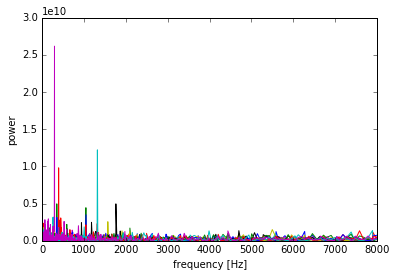

In [173]:
file1 = 'sound_files/1.aif'
result1 = find_notes(file1, notes_freq, notes_name)
file2 = 'sound_files/2.aif'
result2 = find_notes(file2, notes_freq, notes_name)
file3 = 'sound_files/3.aif'
result3 = find_notes(file3, notes_freq, notes_name)
file4 = 'sound_files/4.aif'
result4 = find_notes(file4, notes_freq, notes_name)
file5 = 'sound_files/5.aif'
result5 = find_notes(file5, notes_freq, notes_name)
file6 = 'sound_files/6.aif'
result6 = find_notes(file6, notes_freq, notes_name)
file7 = 'sound_files/7.aif'
result7 = find_notes(file7, notes_freq, notes_name)
file8 = 'sound_files/8.aif'
result8 = find_notes(file8, notes_freq, notes_name)
file9 = 'sound_files/9.aif'
result9 = find_notes(file9, notes_freq, notes_name)
file10 = 'sound_files/10.aif'
result10 = find_notes(file10, notes_freq, notes_name)
file11 = 'sound_files/11.aif'
result11 = find_notes(file11, notes_freq, notes_name)
file12 = 'sound_files/12.aif'
result12 = find_notes(file12, notes_freq, notes_name)

The 1 th donimant note is:  A4


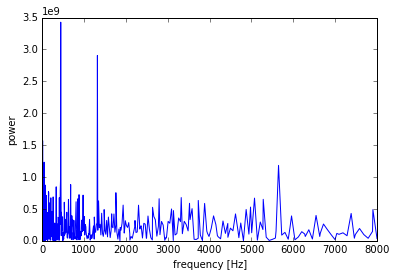

In [221]:
fileA4 = 'sound_files/A4_PopOrgan.aif'
A4=find_notes(fileA4, notes_freq, notes_name)

The 1 th donimant note is:  A4


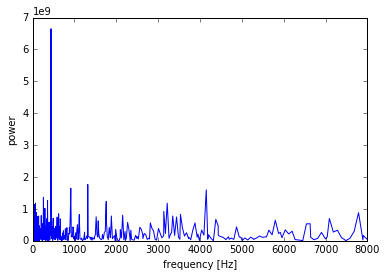

In [222]:
fileA4C4 = 'sound_files/C4A4_PopOrgan.aif'
a4c4=find_notes(fileA4C4, notes_freq, notes_name)


The 1 th donimant note is:  F4


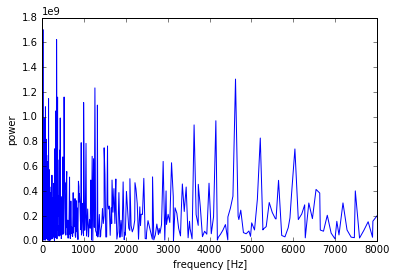

In [223]:
fileF3 = 'sound_files/F3_PopOrgan.aif'
f3=find_notes(fileF3, notes_freq, notes_name)

The 1 th donimant note is:  F4
The 2 th donimant note is:  F5
The 3 th donimant note is:  C6


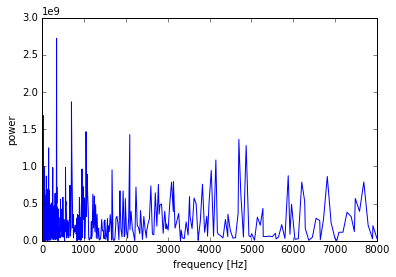

In [224]:
fileF4 = 'sound_files/F4_CathedralOrgan.aif'
f4=find_notes(fileF4, notes_freq, notes_name)

I discussed this Homework with Jing Dai, Kevin Li, Ying Cao